In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)  

# Data Transformation

### Reading and Clean the Dataset

In [3]:
# Load the dataset from the CSV file
electricity_and_weather = pd.read_csv('../data/DATASET_final_untransformed_uncleaned.csv', sep=";")

# Convert the 'Date' column to datetime format for easier handling of time-based data
electricity_and_weather["Date"] = pd.to_datetime(electricity_and_weather["Date"])

# Filter the dataset to only include data from June 1, 2018, onwards
# As reported by Celine, the global radiation dataset starts from this date
electricity_and_weather = electricity_and_weather.drop(
    electricity_and_weather[electricity_and_weather["Date"] < '2018-06-01'].index
)

# Set the 'Date' column as the index for the dataframe for time-based operations
electricity_and_weather.set_index("Date", inplace=True)

# Define valid ranges for each column, which will be used for cleaning the data
# Each column has a specified minimum and maximum range of acceptable values
valid_ranges = {
    'Air_Temperature': (-90, 60),  # Valid range for Air Temperature (°C)
    'Relative_Humidity': (0, 100),  # Valid range for Relative Humidity (%)
    'Visibility': (0, 10),  # Valid range for Visibility (CODE)
    'Air_Pressure_at_Station_Height': (870, 1085),  # Valid range for Air Pressure (hPa)
    'Cloud_Cover': (0, 8),  # Valid range for Cloud Cover (Eighths)
    'Daily_Precipitation_Height': (0, np.inf),  # Valid range for Precipitation (mm)
    'Snow_Height_Daily_Value': (0, np.inf),  # Valid range for Snow Height (cm)
    'Global_Radiation': (0.1, np.inf),  # Valid range for Global Radiation (W/m²)
    'Vapor_Pressure': (0, 70),  # Valid range for Vapor Pressure (hPa)
    'Dew_Point_Temperature': (-80, 30),  # Valid range for Dew Point Temperature (°C)
    'Wind_Direction': (0, 31),  # Valid range for Wind Direction (32-teilig)
    'Wind_Strength': (0, 12),  # Valid range for Wind Strength (Bft)
}

# Function to clean each column by setting values outside the valid range to NaN
# Arguments:
#   x: the data values of a column
#   col_name: the name of the column to check
def clean_column(x, col_name):
    # Retrieve the valid range for the current column from the dictionary
    min_val, max_val = valid_ranges.get(col_name, (None, None))
    
    # If valid range is specified, filter out values outside the range by replacing them with NaN
    if min_val is not None and max_val is not None:
        return x.where((x >= min_val) & (x <= max_val), np.nan)
    
    # If no valid range is provided, return the column as is
    return x

# Apply the cleaning function to all columns in the dataframe
for col in electricity_and_weather.columns:
    electricity_and_weather[col] = clean_column(electricity_and_weather[col], col)


### Imputing Missing Values

In [4]:
from sklearn.experimental import enable_iterative_imputer  # This is necessary to enable IterativeImputer
from sklearn.impute import IterativeImputer

# Initialize IterativeImputer (MICE method)
imputer = IterativeImputer(max_iter=10, random_state=0)

# Impute missing values and convert back to DataFrame with original columns
electricity_and_weather_imputed = pd.DataFrame(imputer.fit_transform(electricity_and_weather), 
                                               columns=electricity_and_weather.columns)

# Clip negative values to 0 for all columns after imputation, except 'Dew_Point_Temperature' and 'Air_Temperature', 
# as these columns can validly contain negative values (e.g., for temperatures below freezing).
columns_to_clip = electricity_and_weather_imputed.columns.difference(['Dew_Point_Temperature', 'Air_Temperature'])

# Apply clipping for all columns except the ones in the exclusion list
electricity_and_weather_imputed[columns_to_clip] = electricity_and_weather_imputed[columns_to_clip].clip(lower=0)

# Restore the original index and update the original dataframe
electricity_and_weather_imputed.index = electricity_and_weather.index

# Exploratory Data Analysis

### Data Visualization

In [5]:
# # Set up the figure and axes
# num_columns = len(electricity_and_weather_imputed.columns)
# fig, axes = plt.subplots(num_columns, 1, figsize=(num_columns, num_columns*1.5))  # Adjust figsize as needed

# # Define a color palette (you can adjust the palette)
# palette = sns.color_palette("dark", n_colors=num_columns)

# # Loop through each column and plot it in the corresponding subplot with a different color
# for i, column in enumerate(electricity_and_weather_imputed.columns):
#     sns.lineplot(data=electricity_and_weather_imputed, x=electricity_and_weather_imputed.index, y=column, ax=axes[i], color=palette[i])
#     axes[i].set_title(column)
#     axes[i].set_xlabel('Date')
#     axes[i].set_ylabel('Value')
#     axes[i].grid(True)

# # Adjust layout for better spacing
# plt.tight_layout()

# # Show the plots
# plt.show()

In [6]:
# # Set Date as the index for correlation
# scale = 8
# # Create a correlation matrix
# corr_matrix = electricity_and_weather_imputed.corr()
# plt.figure(figsize=(2*scale, 1*scale))
# # Create a heatmap to visualize the correlation matrix
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm',
#             fmt=".2f", linewidths=0.5)

# # Show the plot
# plt.title('Correlation Heatmap')
# plt.show()

# Feature Engineering

### Feature Exploration

In [7]:
# Compute correlation matrix
corr_matrix = electricity_and_weather_imputed.corr().abs()  # Use absolute values to check both positive & negative correlation

# Select upper triangle of correlation matrix (to avoid duplicate pairs)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find feature pairs with correlation above a threshold (e.g., 0.85)
threshold = 0.85
highly_correlated_pairs = []

for col in upper.columns:
    for row in upper.index:
        if upper.loc[row, col] > threshold:
            highly_correlated_pairs.append((row, col, upper.loc[row, col]))

# Convert to DataFrame for better readability
correlated_df = pd.DataFrame(highly_correlated_pairs, columns=["Feature 1", "Feature 2", "Correlation"])
correlated_df = correlated_df.sort_values(by="Correlation", ascending=False)

# Display results
print("Highly Correlated Feature Pairs (Threshold > 0.85):")
display(correlated_df)

Highly Correlated Feature Pairs (Threshold > 0.85):


,Feature 1,Feature 2,Correlation
2,Air_Temperature,Dew_Point_Temperature,0.975494
3,Vapor_Pressure,Dew_Point_Temperature,0.947575
0,Total (grid load) [MWh] Calculated resolutions,Residual load [MWh] Calculated resolutions,0.933449
1,Air_Temperature,Vapor_Pressure,0.872171


### Finding the Most Important Features for Residual Load

In [8]:
from sklearn.ensemble import RandomForestRegressor

# Define X (features) and y (target variable)
X = electricity_and_weather_imputed.drop(columns=["Residual load [MWh] Calculated resolutions"])  # Drop target variable
y = electricity_and_weather_imputed["Residual load [MWh] Calculated resolutions"]

# Train a simple Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Get feature importance scores
feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Print the top important features
print("Feature Importance Ranking:")
display(feature_importance)

Feature Importance Ranking:


Total (grid load) [MWh] Calculated resolutions       0.891742
Relative_Humidity                                    0.034740
Global_Radiation                                     0.028197
Wind_Strength                                        0.008134
Visibility                                           0.006245
Air_Temperature                                      0.005521
Hydro pumped storage [MWh] Calculated resolutions    0.005215
Air_Pressure_at_Station_Height                       0.004496
Wind_Direction                                       0.003399
Vapor_Pressure                                       0.003167
Cloud_Cover                                          0.002913
Dew_Point_Temperature                                0.002690
Daily_Precipitation_Height                           0.002433
Snow_Height_Daily_Value                              0.001109
dtype: float64

### Execute Feature Engineering

In [9]:
# Add year, month, and day feature
electricity_and_weather_imputed['year'] = electricity_and_weather_imputed.index.year
electricity_and_weather_imputed['month'] = electricity_and_weather_imputed.index.month
electricity_and_weather_imputed['day'] = electricity_and_weather_imputed.index.day

# Create a new column to indicate if the day is a weekend (1 for weekend, 0 for weekday)
electricity_and_weather_imputed['weekend'] = electricity_and_weather_imputed.index.weekday >= 5  # 5 for Saturday, 6 for Sunday

# Removing Dew_Point_Temperature and Vapor_Pressure because of high correlation with air temperature and air temperature correlate more with the residual load
electricity_and_weather_imputed = electricity_and_weather_imputed.drop(["Dew_Point_Temperature", "Vapor_Pressure"], axis=1)
# ===== Phase: Wind Components (u-v decomposition) =====

# Convert wind direction to radians for calculations
electricity_and_weather_imputed['Wind_Direction_rad'] = np.deg2rad(electricity_and_weather_imputed['Wind_Direction'])

# Calculate u and v components
electricity_and_weather_imputed['wind_u'] = electricity_and_weather_imputed['Wind_Strength'] * np.sin(electricity_and_weather_imputed['Wind_Direction_rad'])
electricity_and_weather_imputed['wind_v'] = electricity_and_weather_imputed['Wind_Strength'] * np.cos(electricity_and_weather_imputed['Wind_Direction_rad'])

# Drop the 'Wind_Direction_rad' column if no longer needed
electricity_and_weather_imputed = electricity_and_weather_imputed.drop('Wind_Direction_rad', axis=1)

# Rename some columns
rename_dict = {
    'Total (grid load) [MWh] Calculated resolutions': 'Total_Load',
    'Residual load [MWh] Calculated resolutions': 'Residual_Load',
    'Hydro pumped storage [MWh] Calculated resolutions': 'Hydro_Pumped_Storage'
}
electricity_and_weather_imputed.rename(columns=rename_dict, inplace=True)

# Add lagged total load (1-day lag)
electricity_and_weather_imputed['Total_Load_lag1'] = electricity_and_weather_imputed['Total_Load'].shift(1)

# Add lagged residual load (1-day lag)
electricity_and_weather_imputed['Residual_Load_lag1'] = electricity_and_weather_imputed['Residual_Load'].shift(1)

# Add lagged residual load (1-day lag)
electricity_and_weather_imputed['Hydro_Pumped_Storage_lag1'] = electricity_and_weather_imputed['Hydro_Pumped_Storage'].shift(1)

# List of weather-related feature names to be lagged
weather_features = [
    'Air_Temperature', 'Relative_Humidity', 'Visibility', 'Air_Pressure_at_Station_Height', 
    'Cloud_Cover', 'Daily_Precipitation_Height', 'Snow_Height_Daily_Value', 'Global_Radiation', 
    'Wind_Direction', 'Wind_Strength', 'wind_u', 'wind_v'
]

# Loop over weather features and create lag1 versions
for feature in weather_features:
    electricity_and_weather_imputed[f'{feature}_lag1'] = electricity_and_weather_imputed[feature].shift(1)

# Drop rows with missing values due to lagging (optional, but important for the model)
electricity_and_weather_imputed = electricity_and_weather_imputed.dropna()


# Feature Scaling and Normalization

In [10]:
# SVR requires standardization because it uses distance-based calculations.
# Random Forest & XGBoost do not require scaling, but normalization can still help in some cases.
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd

X = electricity_and_weather_imputed.drop(columns=['Residual_Load'])  # Features
y = electricity_and_weather_imputed['Residual_Load']  # Target

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Standardization for SVR
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Normalization (Min-Max Scaling) if needed
normalizer = MinMaxScaler()
X_train_normalized = normalizer.fit_transform(X_train)
X_test_normalized = normalizer.transform(X_test)

# Model Training

In [ ]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define a function to evaluate models
def evaluate_model(y_true, y_pred, model_name):
    print(f"--- {model_name} ---")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
    print(f"R² Score: {r2_score(y_true, y_pred):.4f}\n")

# Random Forest Model (No need for scaling)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
evaluate_model(y_test, rf_pred, "Random Forest")

# XGBoost Model (No need for scaling)
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
evaluate_model(y_test, xgb_pred, "XGBoost")



# SVR Model (Requires Standardized Data)
svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svr_model.fit(X_train_scaled, y_train)
svr_pred = svr_model.predict(X_test_scaled)
evaluate_model(y_test, svr_pred, "SVR")

--- Random Forest ---
MAE: 7669.9467
RMSE: 9453.8207
R² Score: 0.9157

--- XGBoost ---
MAE: 6787.5795
RMSE: 8561.0871
R² Score: 0.9309

--- SVR ---
MAE: 27349.5788
RMSE: 33613.4909
R² Score: -0.0657



### Visualizing Actual vs Predicted Value

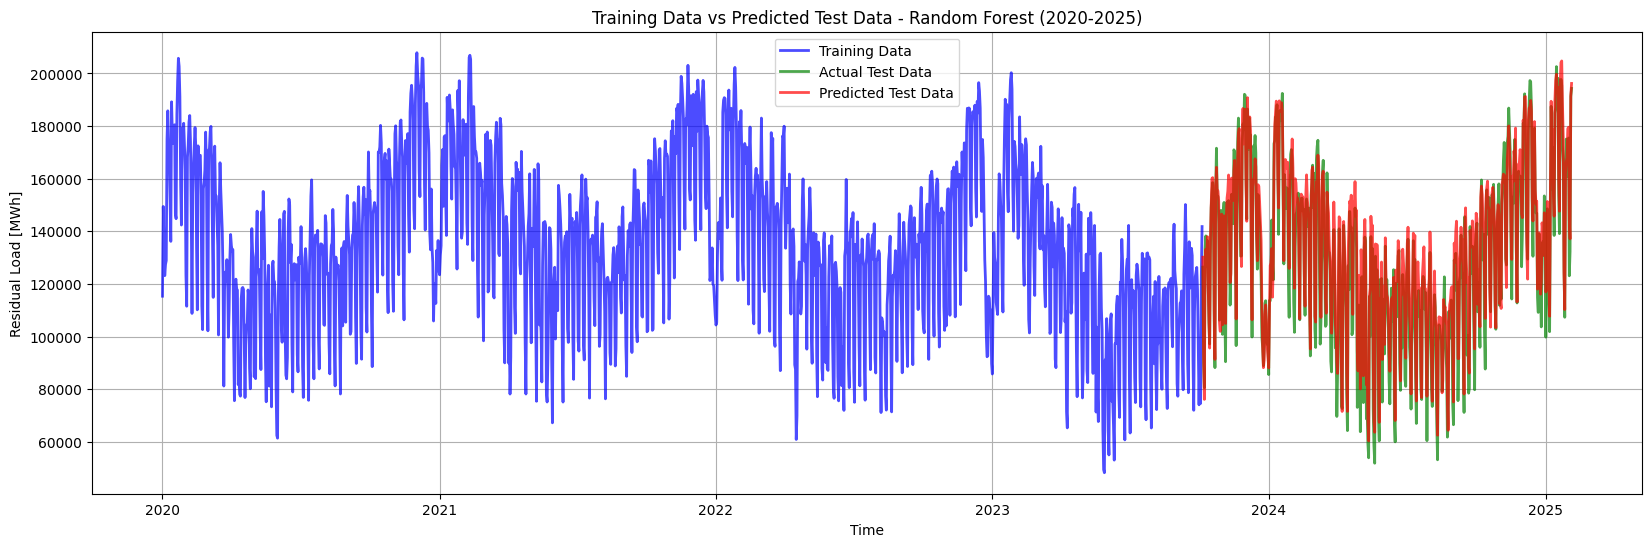

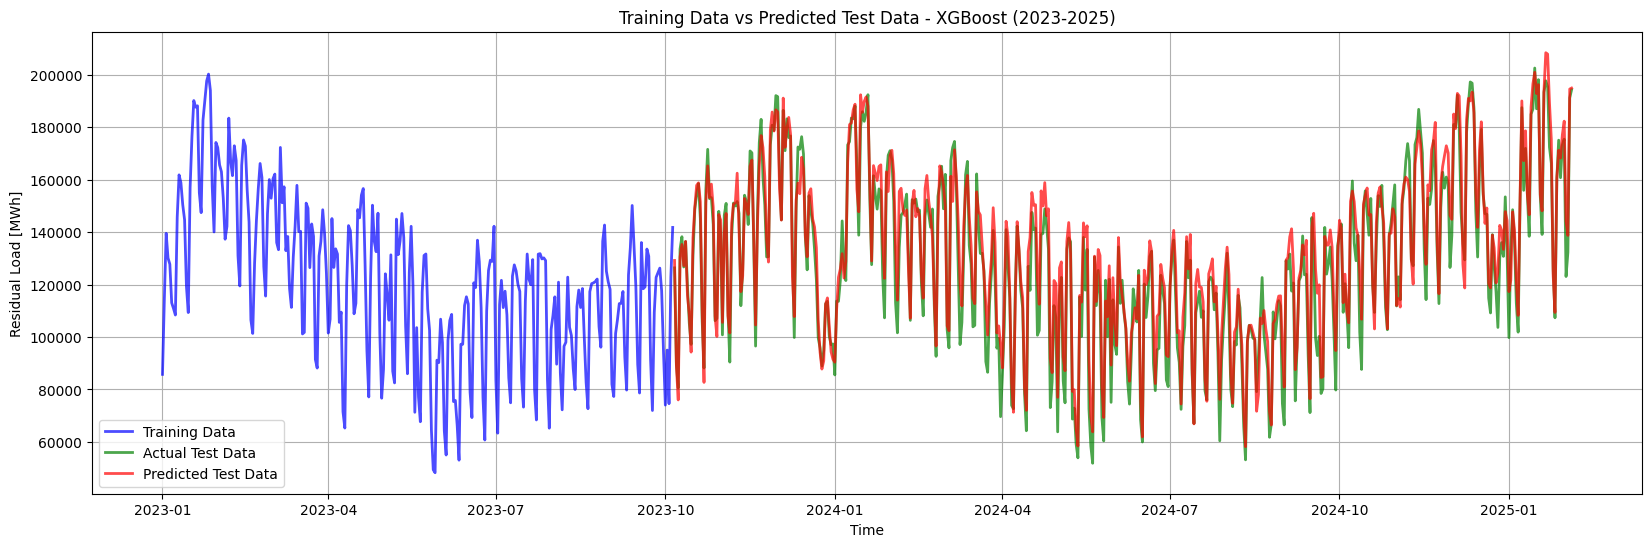

In [13]:
import matplotlib.pyplot as plt

# Function to plot training data and test predictions on top for specific years
def plot_training_vs_predicted_for_years(y_train, y_test, y_pred, model_name, start_year, end_year):
    plt.figure(figsize=(20, 6))

    # Filter the data by the specified years
    y_train_filtered = y_train[(y_train.index.year >= start_year) & (y_train.index.year <= end_year)]
    y_test_filtered = y_test[(y_test.index.year >= start_year) & (y_test.index.year <= end_year)]
    
    # Convert y_pred into a pandas Series with the same index as y_test
    y_pred_filtered = pd.Series(y_pred, index=y_test_filtered.index)
    
    lw= 2
    # Plot the training data (blue line)
    plt.plot(y_train_filtered.index, y_train_filtered, label="Training Data", color="blue", alpha=0.7, linewidth=lw)
    
    # Plot the actual test data (green line)
    plt.plot(y_test_filtered.index, y_test_filtered, label="Actual Test Data", color="green", alpha=0.7, linewidth=lw)
    
    # Plot the predicted test data (red line)
    plt.plot(y_test_filtered.index, y_pred_filtered, label="Predicted Test Data", color="red", alpha=0.7, linewidth=lw)
    
    # Add title, labels, legend, and grid
    plt.title(f"Training Data vs Predicted Test Data - {model_name} ({start_year}-{end_year})")
    plt.xlabel("Time")
    plt.ylabel("Residual Load [MWh]")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:

plot_training_vs_predicted_for_years(y_train, y_test, rf_pred, "Random Forest", 2020, 2025)
plot_training_vs_predicted_for_years(y_train, y_test, xgb_pred, "XGBoost", 2023, 2025)
# plot_training_vs_predicted_for_years(y_train, y_test, svr_pred, "SVR", 2023, 2025)

